In [1]:
!git clone https://github.com/tylin23/netflix-analysis.git

Cloning into 'netflix-analysis'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 31 (delta 9), reused 18 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 10.52 MiB | 7.65 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
# 如果有連上github，就跳過這裡

# 沒連上就另外手動輸入路徑連雲端資料夾
# from google.colab import drive
# drive.mount('/content/drive')

# 一、讀入已清理好的電影資料集

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import warnings


# df = pd.read_csv('/content/drive/MyDrive/netflix_titles.csv')
df = pd.read_csv('/content/netflix-analysis/netflix_data_cleaned/movie_cleaned_data.csv')
df.head()

,show_id,type,show_title,director,cast,year,rating,duration,genres,country,synopsis,show_newid
0,s8206,Movie,The Battle of Midway,John Ford,"Henry Fonda, Jane Darwell",1942,TV-14,18 min,"Classic Movies, Documentaries",United States,Director John Ford captures combat footage of ...,s_0001
1,s8641,Movie,Tunisian Victory,"Frank Capra, John Huston, Hugh Stewart, Roy Bo...",Burgess Meredith,1944,TV-14,76 min,"Classic Movies, Documentaries","United States, United Kingdom",British and American troops join forces to lib...,s_0002
2,s7220,Movie,Know Your Enemy - Japan,"Frank Capra, Joris Ivens","Walter Huston, Dana Andrews",1945,TV-14,63 min,"Classic Movies, Documentaries",United States,Though culturally insensitive by modern standa...,s_0003
3,s7295,Movie,Let There Be Light,John Huston,Walter Huston,1946,TV-PG,58 min,"Classic Movies, Documentaries",United States,Some returning combat veterans suffer scars th...,s_0004
4,s8588,Movie,Thunderbolt,"William Wyler, John Sturges","James Stewart, Lloyd Bridges",1947,TV-PG,42 min,"Classic Movies, Documentaries",United States,A P-47 Thunderbolt squadron is shown in prepar...,s_0005


# 二、把屬於多分類的欄位內所有項目，一一切出來看

## 【1】影片分類genres (多標籤)

In [3]:
# 先將不一致的分隔符（例如 `, ` 和 ` ,`）統一為只有逗號 `, `
df['genres'] = df['genres'].str.replace(r'\s*,\s*', ', ', regex=True)

# 將類別按 `,` 分隔
dd = pd.DataFrame()
dd['genres'] = np.hstack([np.array(i.split(', ')) for i in df['genres'].dropna()])

# 使用 Plotly 繪製條形圖
fig = px.bar(dd.genres.value_counts(), labels={'index':'genres', 'value':'movie count'}, orientation='h')
fig.show()

## 2-1-1 找到所有不重複類別標籤有哪些、總共多少個

In [4]:
# dd['genres'] 已經包含拆掉逗號後的類別

# 獲取所有唯一的類別
unique_genres = np.unique(dd['genres'])
print(unique_genres)  # 顯示所有唯一的類別
print('類別數量為：',len(unique_genres))  # 顯示唯一類別的數量(=有多少個不重複的類別標籤)

['Action & Adventure' 'Action Anime' 'Adult Animation' 'Anime Features'
 'Anime Series' 'Anime based on a Video Game' 'Biographical Documentaries'
 'British TV Shows' 'Children & Family Movies' 'Classic & Cult TV'
 'Classic Movies' 'Comedies' 'Comedy Anime' 'Comedy Movies '
 'Competition Reality TV' 'Courtroom TV Shows' 'Crime TV Shows'
 'Crime TV Shows ' 'Cult Movies' 'Docudramas' 'Documentaries' 'Docuseries'
 'Docuseries ' 'Dramas' 'Education for Kids' 'Faith & Spirituality'
 'Family Movies' 'Family Watch Together TV' 'Family Watch Together TV '
 'Fantasy Anime' 'Fantasy Anime ' 'Fantasy TV Shows' 'Food & Travel TV'
 'Hip-Hop' 'Historical Anime' 'Historical Documentaries' 'Horror Anime'
 'Horror Movies' 'Independent Movies' 'International Movies'
 'International TV Shows' 'K-Dramas based on Webtoon'
 'Kids & Family Movies' 'Kids Music' "Kids' TV" "Kids' TV "
 'Korean TV Shows' 'LGBTQ Movies' 'Lifestyle' 'Makeover Reality TV'
 'Mecha & Cyborg Anime' 'Medical TV Shows' 'Middle Eastern 

## 2-1-2 對每一部電影的標籤欄位作「多標籤的 one-hot encoding」
舉例：有A類別就在A類位置給1，沒有就給0表示無此類

In [5]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

In [6]:
# unique_genres 包含所有可能的電影類別
unique_genres = sorted(set([genre for sublist in dd['genres'].dropna().apply(lambda x: x.split(', ')) for genre in sublist]))

# 創建標籤生成函數
def generate_label(genres_list):
    label = np.zeros(shape=len(unique_genres))  # 創建一個長度與唯一類別數相同的全零向量
    for genre in genres_list:  # 遍歷該影片的所有類別
        if genre in unique_genres:  # 檢查該類別是否存在於 unique_genres
            index = unique_genres.index(genre)
            label[index] = 1  # 如果類別匹配，就將對應位置的值從0改成1
    return label.astype(int)  # 返回這個標籤向量

# 應用標籤生成函數，並檢查每一行是否有 genres
df['genre_labels_2d'] = df['genres'].apply(lambda x: generate_label(x.split(', ')) if isinstance(x, str) else np.zeros(len(unique_genres)))

# 顯示生成的標籤
print(df[['genres', 'genre_labels_2d']].head(50))


                                               genres  \
0                       Classic Movies, Documentaries   
1                       Classic Movies, Documentaries   
2                       Classic Movies, Documentaries   
3                       Classic Movies, Documentaries   
4                       Classic Movies, Documentaries   
5        Classic Movies, Dramas, International Movies   
6   Children & Family Movies, Classic Movies, Come...   
7                              Classic Movies, Dramas   
8        Classic Movies, Comedies, Independent Movies   
9        Classic Movies, Comedies, Independent Movies   
10       Classic Movies, Dramas, International Movies   
11  Action & Adventure, Classic Movies, Sci-Fi & F...   
12                             Classic Movies, Dramas   
13         Classic Movies, Comedies, Music & Musicals   
14       Classic Movies, Dramas, International Movies   
15                       Dramas, International Movies   
16            Classic Movies, D

## 【2】 導演director (多標籤)

In [7]:
# 先將不一致的分隔符（例如 `, ` 和 ` ,`）統一為只有逗號 `, `
df['director'] = df['director'].str.replace(r'\s*,\s*', ', ', regex=True)

# 將導演按 `,` 分隔
dd = pd.DataFrame()
dd['director'] = np.hstack([np.array(i.split(', ')) for i in df['director'].dropna()])

# 使用 Plotly 繪製條形圖
fig = px.bar(dd.director.value_counts(), labels={'index':'director', 'value':'movie count'}, orientation='h')
fig.show()

## 2-2-1 找到所有不重複導演有哪些人、總共多少人

In [8]:
# dd['director'] 已經包含拆掉逗號後的導演

# 獲取所有唯一的導演
unique_director = np.unique(dd['director'])
print(unique_director)  # 顯示所有唯一的導演
print('不重複出現的導演人數為：',len(unique_director))  # 顯示唯一導演的數量(=有多少個不重複的導演標籤)

['A. L. Vijay' 'A. Raajdheep' 'A. Salaam' ... 'Óskar Thór Axelsson'
 'Ömer Faruk Sorak' 'Şenol Sönmez']
不重複出現的導演人數為： 5182


## 2-2-2 對每一位導演的標籤欄位作「多標籤的 one-hot encoding」
舉例：有A人就在A位置給1，沒有就給0表示無此人參與

In [9]:
# unique_director 包含所有可能的電影導演
unique_director = sorted(set([director for sublist in dd['director'].dropna().apply(lambda x: x.split(', ')) for director in sublist]))

# 創建標籤生成函數
def generate_director(director_list):
    label = np.zeros(shape=len(unique_director))  # 創建一個長度與唯一導演數相同的全零向量
    for director in director_list:  # 遍歷該影片的所有導演
        if director in unique_director:  # 檢查該導演是否存在於 unique_director
            index = unique_director.index(director)
            label[index] = 1  # 如果導演名字匹配，就將對應位置的值從0改成1
    return label.astype(int)  # 返回這個標籤向量

# 應用標籤生成函數，並檢查每一行是否有 genres
df['director_labels_2d'] = df['director'].apply(lambda x: generate_label(x.split(', ')) if isinstance(x, str) else np.zeros(len(unique_director)))

# 顯示生成的標籤
print(df[['director', 'director_labels_2d']].head(50))

                                             director  \
0                                           John Ford   
1   Frank Capra, John Huston, Hugh Stewart, Roy Bo...   
2                            Frank Capra, Joris Ivens   
3                                         John Huston   
4                         William Wyler, John Sturges   
5                                     Youssef Chahine   
6                                      Michael Curtiz   
7                                        Nicholas Ray   
8                                           Dino Risi   
9                                           Dino Risi   
10                                    Youssef Chahine   
11                                     Fred M. Wilcox   
12                                     Richard Brooks   
13                 Vincente Minnelli, Charles Walters   
14                                    Youssef Chahine   
15                                      Naresh Saigal   
16                             

## 【3】 演員卡司cast (多標籤)

In [10]:
# 先將不一致的分隔符（例如 `, ` 和 ` ,`）統一為只有逗號 `, `
df['cast'] = df['cast'].str.replace(r'\s*,\s*', ', ', regex=True)

# 將演員按 `,` 分隔
dd = pd.DataFrame()
dd['cast'] = np.hstack([np.array(i.split(', ')) for i in df['cast'].dropna()])

# 使用 Plotly 繪製條形圖
fig = px.bar(dd.cast.value_counts(), labels={'index':'cast', 'value':'movie count'}, orientation='h')
fig.show()

## 2-2-1 找到所有不重複演員有哪些人、總共多少人

In [11]:
# dd['cast'] 已經包含拆掉逗號後的演員

# 獲取所有唯一的演員
unique_cast = np.unique(dd['cast'])
print(unique_cast)  # 顯示所有唯一的演員
print('不重複出現的演員人數為：',len(unique_cast))  # 顯示唯一演員的數量(=有多少個不重複的演員標籤)

['"Riley" Lakdhar Dridi' "'Najite Dede" '2Mex' ... 'Şükran Ovalı'
 'Şükrü Özyıldız' 'Ṣọpẹ́ Dìrísù']
不重複出現的演員人數為： 26386


## 2-3-2 對每一位演員的標籤欄位作「多標籤的 one-hot encoding」
舉例：有A人就在A位置給1，沒有就給0表示無此人參與

In [12]:
# unique_cast 包含所有可能的演員
unique_cast = sorted(set([cast for sublist in dd['cast'].dropna().apply(lambda x: x.split(', ')) for cast in sublist]))

# 創建標籤生成函數
def generate_cast(cast_list):
    label = np.zeros(shape=len(unique_cast))  # 創建一個長度與唯一演員數相同的全零向量
    for cast in cast_list:  # 遍歷該影片的所有演員
        if cast in unique_cast:  # 檢查該演員是否存在於 unique_cast
            index = unique_cast.index(cast)
            label[index] = 1  # 如果演員名字匹配，就將對應位置的值從0改成1
    return label.astype(int)  # 返回這個標籤向量

# 應用標籤生成函數，並檢查每一行是否有 cast
df['cast_labels_2d'] = df['cast'].apply(lambda x: generate_label(x.split(', ')) if isinstance(x, str) else np.zeros(len(unique_cast)))

# 顯示生成的標籤
print(df[['cast', 'cast_labels_2d']].head(50))

                                                 cast  \
0                           Henry Fonda, Jane Darwell   
1                                    Burgess Meredith   
2                         Walter Huston, Dana Andrews   
3                                       Walter Huston   
4                        James Stewart, Lloyd Bridges   
5   Omar Sharif, Faten Hamama, Zaki Rostom, Farid ...   
6   Bing Crosby, Danny Kaye, Rosemary Clooney, Ver...   
7   James Dean, Natalie Wood, Sal Mineo, Jim Backu...   
8   Vittorio De Sica, Sophia Loren, Lea Padovani, ...   
9   Sophia Loren, Franca Valeri, Vittorio De Sica,...   
10  Faten Hamama, Omar Sharif, Ahmed Ramzy, Hussei...   
11  Leslie Nielsen, Walter Pidgeon, Anne Francis, ...   
12  Elizabeth Taylor, Paul Newman, Burl Ives, Jack...   
13  Leslie Caron, Maurice Chevalier, Louis Jourdan...   
14  Farid Shawqy, Hind Rostom, Youssef Chahine, Ha...   
15  Mala Sinha, Shammi Kapoor, Raaj Kumar, Leela C...   
16  Elizabeth Taylor, Laurence 

## 【特1】檢查內容多樣性

### 電影分類

In [13]:
# 檢查標籤生成後的多樣性
print(np.unique(np.array(df['genre_labels_2d'].tolist()), return_counts=True))

# 檢查一個具體樣本的標籤
print(df[['genres', 'genre_labels_2d']].iloc[0])


(array([0, 1]), array([640564,  13826]))
genres                                 Classic Movies, Documentaries
genre_labels_2d    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
Name: 0, dtype: object


### 導演

In [14]:
# 檢查標籤生成後的多樣性
print(np.unique(np.array(df['director'].tolist()), return_counts=True))

# 檢查一個具體樣本的標籤
print(df[['director', 'director_labels_2d']].iloc[0])


(array(['A. L. Vijay', 'A. Raajdheep', 'A. Salaam', ...,
       'Óskar Thór Axelsson', 'Ömer Faruk Sorak', 'Şenol Sönmez'],
      dtype='<U208'), array([2, 1, 1, ..., 1, 2, 2]))
director                                                      John Ford
director_labels_2d    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 0, dtype: object


### 演員卡司

In [15]:
# 檢查標籤生成後的多樣性
print(np.unique(np.array(df['cast'].tolist()), return_counts=True))

# 檢查一個具體樣本的標籤
print(df[['cast', 'cast_labels_2d']].iloc[0])


(array(['50 Cent, Ryan Phillippe, Bruce Willis, Rory Markham, Jenna Dewan, Brett Granstaff, Randy Couture, Susie Abromeit, Ron Turner, James Remar',
       'A.J. LoCascio, Sendhil Ramamurthy, Fred Tatasciore, Jake Johnson, Lauren Lapkus, Zachary Levi, BD Wong, David Gunning',
       'Aadhi, Tapsee Pannu, Ritika Singh, Vennela Kishore, Sapthagiri',
       ..., 'İbrahim Büyükak, Zeynep Koçak, Gupse Özay, Cengiz Bozkurt',
       'Şahin Irmak, İrem Sak, Gonca Vuslateri, Emre Karayel, Duygu Yetiş, Onur Buldu, Salih Kalyon, Bilge Şen, Nilgün Belgün, Hakan Akın',
       'Ṣọpẹ́ Dìrísù, Wunmi Mosaku, Matt Smith, Malaika Wakoli-Abigaba'],
      dtype='<U632'), array([1, 1, 1, ..., 1, 1, 1]))
cast                                      Henry Fonda, Jane Darwell
cast_labels_2d    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 0, dtype: object


## 【4】片長
因為欄位內容有含"min"，去掉而只留實際分鐘數
"123 min" --> "123"

In [18]:
import pandas as pd

# df 是你的資料集
# 使用 apply 來進行條件判斷和處理
def extract_minutes(duration):
    if 'min' in duration:
        return int(duration.replace('min', '').strip())
    else:
        return duration  # 保留原來的非分鐘數值，像是"1 Season"表示一季，先留下來

# 應用函數進行處理
df['duration_processed'] = df['duration'].apply(extract_minutes)

# 檢查處理後的資料
print(df[['duration', 'duration_processed']].head())
df[['duration', 'duration_processed']]

# 保留原來的非分鐘數值，像是"1 Season"表示一季，先留下來

  duration duration_processed
0   18 min                 18
1   76 min                 76
2   63 min                 63
3   58 min                 58
4   42 min                 42


,duration,duration_processed
0,18 min,18
1,76 min,76
2,63 min,63
3,58 min,58
4,42 min,42
...,...,...
5944,1 Season,1 Season
5945,1 Season,1 Season
5946,1 Season,1 Season
5947,1 Season,1 Season


## 上述多標籤與片長等欄位內容都處理完畢，進行存檔備用
存入一新資料集：data

In [19]:
data = pd.DataFrame()
data['show_newid'] = df.dropna()['show_newid']
data['type'] = df.dropna()['type']
data['show_title'] = df.dropna()['show_title']

# 多分類欄位：導演、演員、分類
data['director'] = df.dropna()['director_labels_2d']
data['cast'] = df.dropna()['cast_labels_2d']
data['label'] = df.dropna()['genre_labels_2d']

data['year'] = df.dropna()['year']
data['rating'] = df.dropna()['rating']
data['country'] = df.dropna()['country']

# 片長欄位
data['duration'] = df.dropna()['duration_processed']


# 查看生成的標籤
print(data.head(10))
print(data.shape)
print(data.info)

  show_newid   type               show_title  \
0     s_0001  Movie     The Battle of Midway   
1     s_0002  Movie         Tunisian Victory   
2     s_0003  Movie  Know Your Enemy - Japan   
3     s_0004  Movie       Let There Be Light   
4     s_0005  Movie              Thunderbolt   
5     s_0006  Movie          The Blazing Sun   
6     s_0007  Movie          White Christmas   
7     s_0008  Movie    Rebel Without a Cause   
8     s_0009  Movie      Scandal in Sorrento   
9     s_0010  Movie        The Sign of Venus   

                                            director  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7  [0, 0, 0, 0, 0, 0, 0

### 確認data有存到內容

In [20]:
# 檢查標籤生成後的多樣性
print(np.unique(np.array(data['label'].tolist()), return_counts=True))

# 檢查一個具體樣本的標籤
print(data[['label']].iloc[0])

(array([0, 1]), array([640564,  13826]))
label    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
Name: 0, dtype: object


# 三、將「電影描述」一個個字詞拆出來



## 3-1 先移除描述的標點符號、轉換大小寫

In [21]:
import re

def clean_text(text):
    # 移除標點符號，只保留字母、數字和空白
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()  # 轉換為小寫
    return text

# 應用清理函數到 'synopsis' 欄位
df['synopsis_processed'] = df['synopsis'].apply(clean_text)

# 檢查處理後的資料

print(df[['synopsis_processed']].head())


                                  synopsis_processed
0  director john ford captures combat footage of ...
1  british and american troops join forces to lib...
2  though culturally insensitive by modern standa...
3  some returning combat veterans suffer scars th...
4  a p47 thunderbolt squadron is shown in prepara...


## 3-2畫長條圖，看描述的字數長度分布狀況
算百分位數值90%-100%的字數是多少？（類似PR值概念，PR90-100的意思）

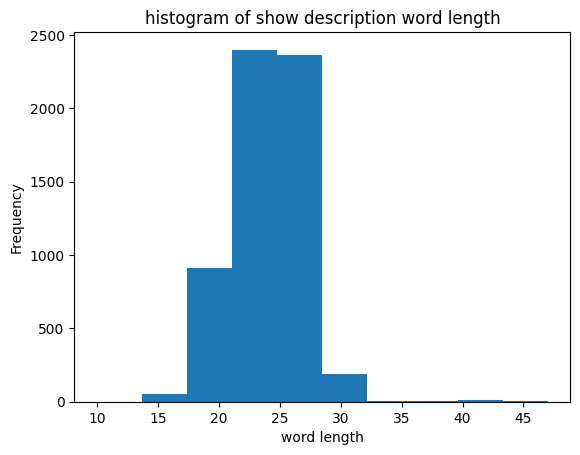

word length at 90 percentile: 27.0
word length at 91 percentile: 27.0
word length at 92 percentile: 28.0
word length at 93 percentile: 28.0
word length at 94 percentile: 28.0
word length at 95 percentile: 28.0
word length at 96 percentile: 28.0
word length at 97 percentile: 29.0
word length at 98 percentile: 29.0
word length at 99 percentile: 30.0


In [23]:
# 定義函數計算每個「電影描述」的字數
def get_wordlen(x):
    return len(x.split()) #按空格分開後，存成列表，計算列表內長度（字詞數量）


data['len'] = df.synopsis_processed.apply(get_wordlen) #抓前面處理過的資料集「synopsis_processed」欄位的內容計算字數存成data['len']
data['len'].plot(kind='hist') # 畫出長條圖

plt.title('histogram of show description word length')
plt.xlabel('word length')
plt.show()

for i in np.arange(0.9,1,0.01):
    p = data.len.quantile(i)
    print(f'word length at {int(i*100)} percentile:',p)

## 3-3 停用詞處理，減少數據量


### 3-3-1 去除像介詞、連接詞、冠詞等常見的停用詞（stopwords）
可以減少描述文本中的冗餘信息，並且可能幫助降低數據量。

Python 的 nltk 庫可以去除停用詞。nltk 提供了一個標準的英語停用詞列表

In [24]:
!pip install nltk

使用 punkt 模組來進行文本分詞（tokenization）

In [25]:
import nltk
nltk.download('punkt')  # 下載 punkt 模組
nltk.download('stopwords')  # 確保下載 stopwords

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# 取得英語的停用詞列表
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    # 將文本轉為小寫並移除標點符號
    text = text.lower().translate(str.maketrans('', '', string.punctuation))

    # 使用 word_tokenize 將文本分詞
    words = word_tokenize(text)

    # 過濾掉停用詞
    filtered_words = [word for word in words if word not in stop_words]

    # 返回去除停用詞後的文本
    return ' '.join(filtered_words)

# 包含整理後的影片描述之欄位
df['cleaned_synopsis'] = df['synopsis_processed'].apply(remove_stopwords)

# 檢查去除停用詞後的文本
print(df['cleaned_synopsis'].head())



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    director john ford captures combat footage bat...
1    british american troops join forces liberate n...
2    though culturally insensitive modern standards...
3    returning combat veterans suffer scars psychol...
4    p47 thunderbolt squadron shown preparation pla...
Name: cleaned_synopsis, dtype: object


## cleaned_synopsis存入資料集：data

In [26]:
# 確保 cleaned_synopsis 被存回到 data 中
data['cleaned_synopsis'] = df['cleaned_synopsis'].apply(remove_stopwords)

# 檢查 data 中是否有 cleaned_synopsis 欄位
print(data.columns)
print(data.head())  # 檢查 data 的前幾筆資料

Index(['show_newid', 'type', 'show_title', 'director', 'cast', 'label', 'year',
       'rating', 'country', 'duration', 'len', 'cleaned_synopsis'],
      dtype='object')
  show_newid   type               show_title  \
0     s_0001  Movie     The Battle of Midway   
1     s_0002  Movie         Tunisian Victory   
2     s_0003  Movie  Know Your Enemy - Japan   
3     s_0004  Movie       Let There Be Light   
4     s_0005  Movie              Thunderbolt   

                                            director  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                cast  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# 四、把data資料集存出，供未來導入使用

| 特性     | JSON                 | Pickle                 |
|--------|----------------------|------------------------|
| 格式     | 文本格式                 | 二進制格式                  |
| 可讀性    | 高（人類可讀）              | 低（人類不可讀）               |
| 數據類型支持 | 支持基本類型（字典、列表、字符串、數字） | 支持所有 Python 類型，包括自定義類型 |
| 跨語言支持  | 是，適合跨平台和多種語言使用       | 否，僅限於 Python           |
| 文件大小   | 相對較大（文本文件）           | 相對較小（二進制文件）            |
| 速度     | 讀寫速度較慢               | 讀寫速度較快                 |
| 安全性    | 安全，純文本不會執行任意代碼       | 不安全，反序列化時可能執行惡意代碼      |
| 應用場景   | 用於與其他系統或語言交換數據       | 用於 Python 內部存儲和數據交換    |
| 可擴展性   | 跨平台、易於擴展             | 僅限 Python，無法跨語言擴展      |
| 適用場景   | 簡單數據、與外部系統互動         | 複雜數據結構、僅 Python 內部使用   |


## 4-1 存出json

In [31]:
import pandas as pd
from google.colab import files

In [33]:
# 保存為 json
data.to_json('movie_data_all.json', orient='records')

# 下載文件
files.download('movie_data_all.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4-2 存出pickle

In [ ]:
import pickle

In [30]:
# 保存為 Pickle
data.to_pickle('movie_data_all.pkl')

# 下載文件
files.download('movie_data_all.pkl')

# 讀取 Pickle語法
# df = pd.read_pickle('data.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>